# OpenAPS IOB Calculations
----
The code in this notebook will replicate and visualize the IOB calculations used in the [OpenAPS project](https://github.com/openaps/oref0).

Specifically, it will replicate the javascript code found in [`OpenAPS/oref0/lib/iob/calculation.js`](https://github.com/openaps/oref0/blob/master/lib/iob/calculate.js) and plot insulin action curves for a set of Duration of Insulin Activity (`dia`) values.

Two examples of what I think we're aiming to replicate can be found...

Here: [http://journals.sagepub.com/doi/pdf/10.1177/193229680900300319](http://journals.sagepub.com/doi/pdf/10.1177/193229680900300319)

and

Here: [https://www.hindawi.com/journals/cmmm/2015/281589/](https://www.hindawi.com/journals/cmmm/2015/281589/)




In [280]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [281]:
# Coefficients used in estimating the percent of insulin remaining, or (alternatively) the insulin action/decay curve.
# Coeff[0] = alpha * 1
# Coeff[1] = beta1 * x^2
# Coeff[2] = beta2 * x
insulin_action_coeffs = [[1.000000, -0.001852, 0.001852],   # Applied between [0,peak)
                         [0.555560, 0.001323, -0.054233]]   # Applied between [peak,end)
# Source: ?????

In [282]:
def calc_IOB(dia):
    
    peak = 75
    end = 180
    
    x_list = []
    iob_list = [] 
    
    for i_min in range(0, dia * 60):
        
        i_min = i_min * 3.0 / dia
        
        if (i_min < peak):
            x = (i_min / 5) + 1 # Why + 1? Should there be a i_min = 0 condition that returns iob_pct = 1?
            x_list.append(x)
            iob_pct = insulin_action_coeffs[0][0] + insulin_action_coeffs[0][1] * x**2 + insulin_action_coeffs[0][2] * x
            iob_list.append(iob_pct)
        elif (i_min < end):
            x = (i_min - peak) / 5 # Also, why / 5? Is this just b/c the coefficients were estimated in 5 min intervals?
            x_list.append(x)
            iob_pct = insulin_action_coeffs[1][0] + insulin_action_coeffs[1][1] * x**2 + insulin_action_coeffs[1][2] * x
            iob_list.append(iob_pct)
    
    return x_list, iob_list   

In [283]:
# Create a dictionary of DataFrames -- one for each value of DIA between 2 and 8
dict_of_dfs_by_dia = {}

for dia in range(2, 9):                           # NB: range() ends at n-1
    x_list, iob_list = calc_IOB(dia)
    iob_df = pd.DataFrame({'x' : x_list, 'iob_pct_dia_' + str(dia) : iob_list})
    dict_of_dfs_by_dia.update({dia : iob_df})

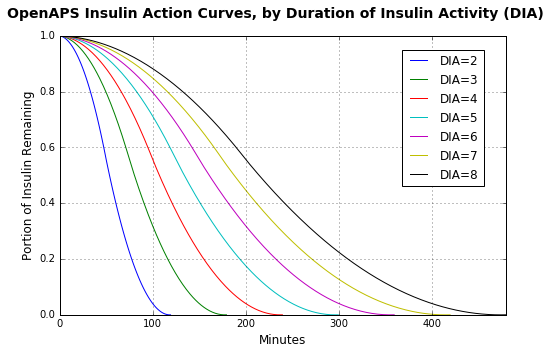

In [313]:
# Now plot the curves
plt.figure(figsize=(8, 5))
plt.axis([0,480,0,1])
plt.ylabel('Portion of Insulin Remaining', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Insulin Action Curves, by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

for dia in range(2,9):
    dia_str = str(dia)
    dict_of_dfs_by_dia[dia]['iob_pct_dia_' + dia_str].plot(kind='line', label='DIA='+dia_str).grid(True)

plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.)
plt.savefig('OpenAPS_insulin_action_curves_by_dia.png', format='png', dpi=600)
plt.show()   